## Задание
Выберите ряд из первого задания и постройте его модель GARCH. Отчет нужно будет оформить в jupyter-ноутбук.

In [2]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline

### Функции

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [15]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


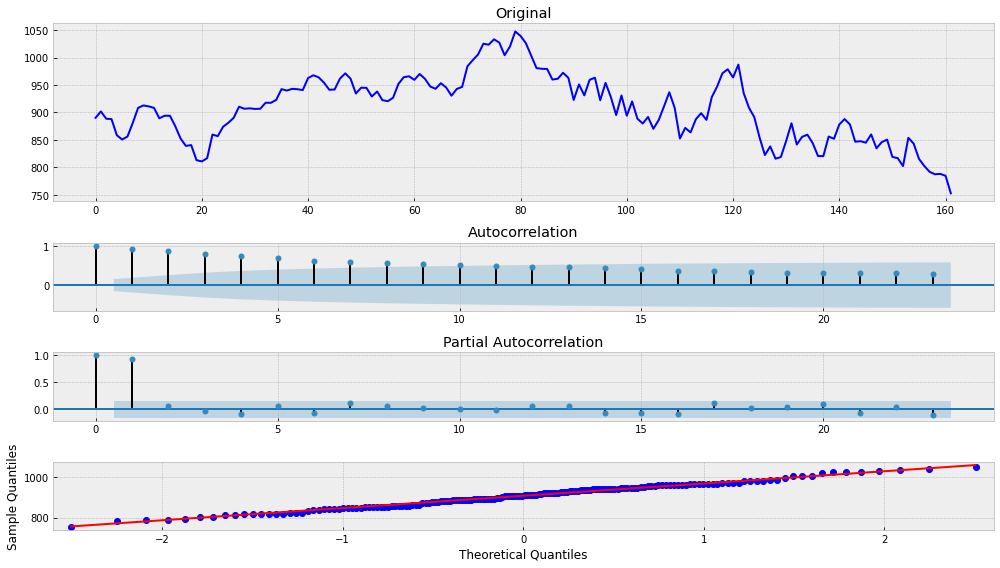

In [5]:
series = pd.read_csv('weekly-closings-of-the-dowjones-.csv')['Close']
tsplot(series)

Делаем стационарный ряд

Results of Dickey-Fuller Test:
Test Statistic                  -5.598128
p-value                          0.000001
#Lags Used                       5.000000
Number of Observations Used    155.000000
Critical Value (1%)             -3.473259
Critical Value (5%)             -2.880374
Critical Value (10%)            -2.576812
dtype: float64


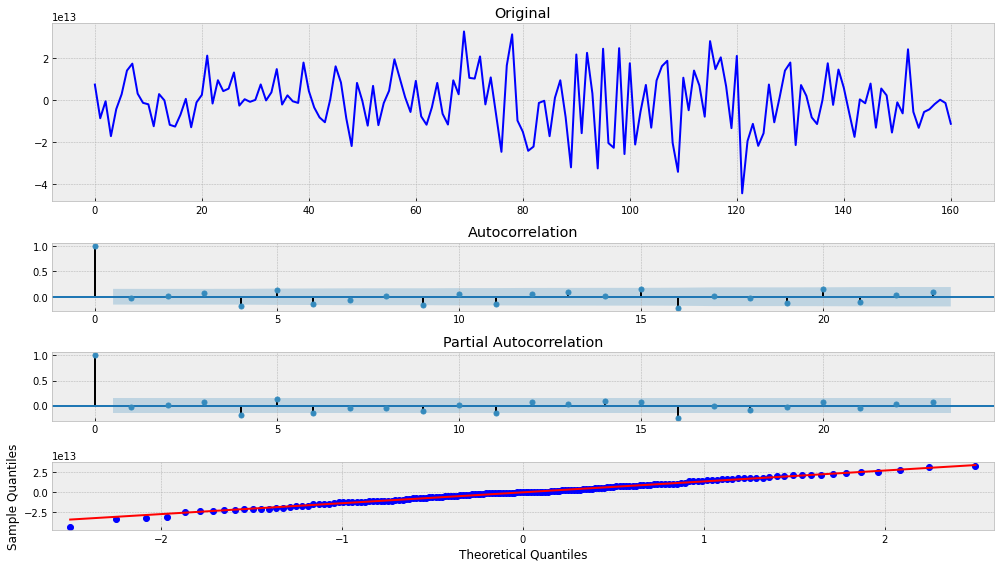

In [6]:
series = boxcox(series, 5)
series = series[1:] - series[:-1]
tsplot(series)

Плучаем лучшие веса для модели

In [16]:
aic, order, mdl = _get_best_model(series)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  interval : int
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  interval : int
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  interval : int


aic: 10090.16046 | order: (2, 2, 4)


Results of Dickey-Fuller Test:
Test Statistic                -1.244203e+01
p-value                        3.734809e-23
#Lags Used                     0.000000e+00
Number of Observations Used    1.580000e+02
Critical Value (1%)           -3.472431e+00
Critical Value (5%)           -2.880013e+00
Critical Value (10%)          -2.576619e+00
dtype: float64


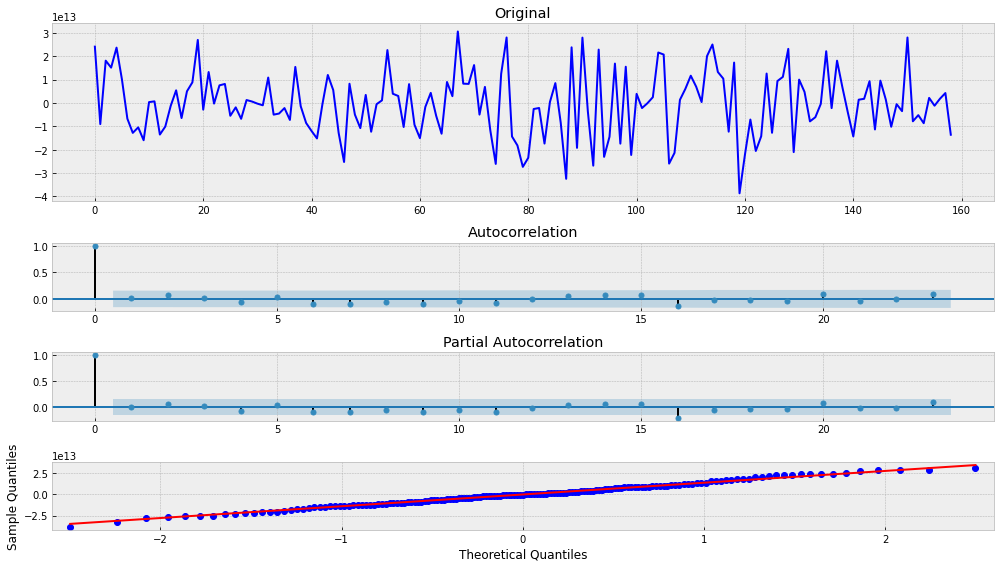

In [17]:
tsplot(mdl.resid)

In [20]:
order

(2, 2, 4)

### GARCH

In [21]:
from arch import arch_model

In [26]:
p_ = order[0]
o_ = order[1]
q_ = order[2]

am = arch_model(pd.Series(series), p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     69,   Neg. LLF: 5090.085712901226
Iteration:     10,   Func. Count:    137,   Neg. LLF: 5089.4276969002785
Iteration:     15,   Func. Count:    202,   Neg. LLF: 5089.185838960642
Iteration:     20,   Func. Count:    267,   Neg. LLF: 5088.911065944474
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5088.878243006469
            Iterations: 23
            Function evaluations: 317
            Gradient evaluations: 23
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -5088.88
Distribution:      Standardized Student's t   AIC:                           10199.8
Method:                  Maximum Likelihood   BIC:                         

/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.876e+26. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1e-12 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Смотрим на остатки

Results of Dickey-Fuller Test:
Test Statistic                  -5.598128
p-value                          0.000001
#Lags Used                       5.000000
Number of Observations Used    155.000000
Critical Value (1%)             -3.473259
Critical Value (5%)             -2.880374
Critical Value (10%)            -2.576812
dtype: float64


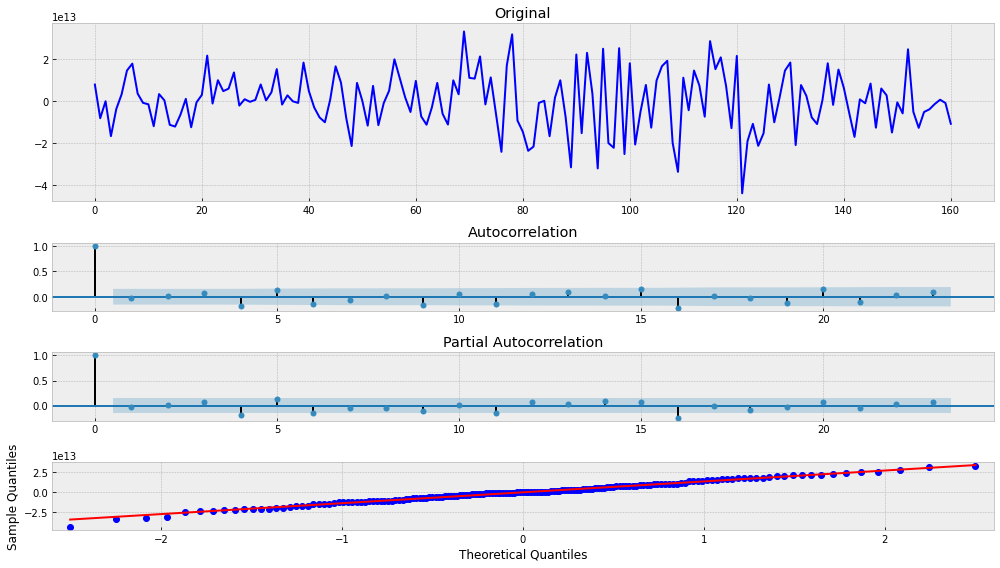

In [27]:
tsplot(res.resid)

In [29]:
forecast = res.forecast(horizon=3)

/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


In [31]:
forecast.residual_variance.iloc[-1] ** 0.05

h.1    20.162175
h.2    20.091820
h.3    20.190877
Name: 160, dtype: float64

Какие были последние значения

In [32]:
pd.Series(series).rolling(3).std()

0               NaN
1               NaN
2      8.008867e+12
3      8.306671e+12
4      8.718185e+12
           ...     
156    4.763865e+12
157    1.932055e+12
158    2.288776e+12
159    1.065616e+12
160    6.206570e+12
Length: 161, dtype: float64